In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Install IPD package
### Option 1 (from source):
1. Clone this github repo
2. Run `pip install -e .[render]` 
    1. Make sure you are using a compatible python version (tested with 3.10.14)
    2. Recommend using a venv

### Option 2 (not available yet):
1. `pip install intrinsic-ipd[render]`

In [3]:
import intrinsic_ipd as ipd
from intrinsic_ipd import IPDataset, IPDCamera, IPDImage
from intrinsic_ipd.constants import CameraFramework
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

## 2. Download (if not exists) and load dataset

In [5]:
ipd_reader = IPDataset("./datasets", "dataset_darkbg_0", IPDCamera.PHOTONEO, download=True)
ipd_reader.objects

INFO:intrinsic_ipd.ipd:
	Dataset Path:	./datasets/dataset_darkbg_0/test
	Camera Type:	Photoneo 	 000
	Num Scenes:	90


[('gear2', 0),
 ('gear2', 1),
 ('gear2', 2),
 ('gear2', 3),
 ('gear2', 4),
 ('hex_manifold', 0),
 ('hex_manifold', 1)]

## 3. Render

Note that the rendering code uses `pyrender` for offscreen rendering. Please specify a compatible backend. See pyrender's official documentation [here](https://pyrender.readthedocs.io/en/latest/examples/offscreen.html).

INFO:intrinsic_ipd.ipd:Opening image from ./datasets/dataset_darkbg_0/test/000010/000/rgb/000000.png


[ WARN:0@2.256] global matrix_expressions.cpp:1333 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


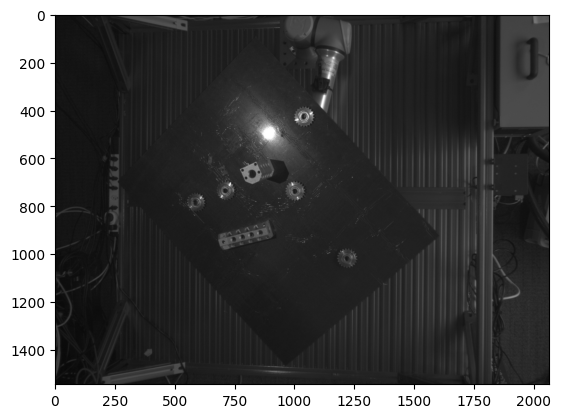

In [6]:
scene = 10
im = ipd_reader.get_img(scene_id=scene, image_type=IPDImage.PHOTONEO_HDR)
plt.imshow(im)

In [7]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'
color, depth = ipd_reader.render(scene_id=scene)

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## 4. Display or Save

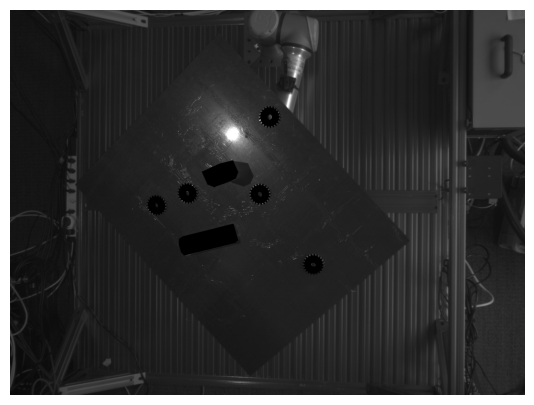

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(im)
plt.imshow(color, alpha=1)
# plt.show()

In [9]:
# %matplotlib agg

# fig = plt.figure(figsize=(10, 5))
# plt.axis('off')
# plt.imshow(im, alpha=1)
# plt.imshow(color, alpha=1)
# plt.savefig(f'image_{ipd_reader.dataset_id}_{ipd_reader.camera.type}.png', bbox_inches='tight')
# print(f"Image saved to './image_{ipd_reader.dataset_id}_{ipd_reader.camera.type}.png'")

## 5. Get masks of objects

#### 5.1 Render (but don't save) masks for all objects in a scene

In [10]:
# masks = ipd_reader.render_masks(scene_id=scene)
# mask = masks[ipd_reader.objects[0]]

#### 5.2 Generate and Save Masks for all objects in all scenes

In [11]:
# mask_paths = ipd_reader.create_masks(overwrite=True)
mask = ipd_reader.get_mask(scene_id=scene, object_name="hex_manifold", object_id=0, resize=None, detect_bounding_box=False)

#### 5.3 Display Mask

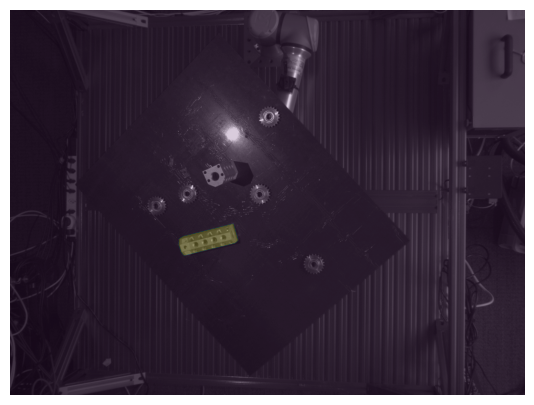

In [12]:
if not mask is None:
    fig = plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(im)
    plt.imshow(mask, alpha=0.2)
    plt.show()

In [ ]:
# Testing
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
im = imageio.imread("./datasets/dataset_basket_0/test/000000/000/rgb/000000.png")
im.shape, np.max(im)

In [ ]:
def get_color(filepath, hdr=False, resize=1):
#   color = imageio.imread(filepath)
  color = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
  if len(color.shape)==2:
    color = cv2.cvtColor(color, cv2.COLOR_GRAY2RGB)
  else:
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
  if np.max(color) > 255 and not hdr:
    # Convert HDR to LDR
    gamma = 2.2
    tonemap = cv2.createTonemap(gamma)
    color = tonemap.process(color.astype(np.float32))
    color = cv2.normalize(color, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  if resize!=1:
    color = cv2.resize(color, fx=resize, fy=resize, interpolation=cv2.INTER_NEAREST, dsize=None)
  return color

In [ ]:
def get_color2(file, resize=1):
    color = imageio.imread(file)[...,:3]
    color = cv2.resize(color, fx=resize, fy=resize, interpolation=cv2.INTER_NEAREST, dsize=None)
    return color

In [ ]:
file1 = "../FoundationPose/demo_data/lm/test/000001/rgb/000000.png"
file2 = "./datasets/dataset_basket_0/test/000000/24466147/rgb/0_80000.png"
(get_color(file1) == get_color2(file1)).all()
get_color(file1).shape

In [ ]:
def get_depth(depth_file, resize=1, zfar=np.inf):
  depth = cv2.imread(depth_file,-1)*1e-3
  if resize!=1:
    depth = cv2.resize(depth, fx=resize, fy=resize, dsize=None, interpolation=cv2.INTER_NEAREST)
  depth[depth<0.1] = 0
  depth[depth>zfar] = 0
  return depth

In [ ]:
fp_depth = get_depth("../FoundationPose/demo_data/lm/test/000001/depth/000000.png", resize=1, zfar=np.inf)
fp_depth.shape, np.max(fp_depth)

In [ ]:
ipd_img = get_color("./datasets/dataset_basket_0/test/000000/000/rgb/000000.png", resize=.3)
ipd_depth = get_depth("./datasets/dataset_basket_0/test/000000/000/depth/000000.png", zfar=np.inf)
ipd_depth.shape, ipd_img.shape

In [ ]:
plt.imshow(ipd_img)
# plt.imshow(ipd_depth, alpha=0.5)

In [ ]:
def get_mask(mask_file, resize=1, detect_type='mask'):
  mask = cv2.imread(mask_file, -1)
  if resize!=1:
    mask = cv2.resize(mask, fx=resize, fy=resize, dsize=None, interpolation=cv2.INTER_NEAREST)
  mask = mask>0
  
  if len(mask.shape)>2:
      mask = mask[:,:,0]

  if detect_type=='box':
    H,W = mask.shape[:2]
    vs,us = np.where(mask>0)
    umin = us.min()
    umax = us.max()
    vmin = vs.min()
    vmax = vs.max()
    valid = np.zeros((H,W), dtype=bool)
    valid[vmin:vmax,umin:umax] = 1
  elif detect_type=='mask':
    
    if mask is None:
      return None
    valid = mask>0
  else:
    raise RuntimeError
  return valid


In [ ]:
fp_mask = get_mask("../FoundationPose/demo_data/lm/test/000001/mask/000000_000000.png", 
                   resize=1, detect_type="box")
fp_mask.shape, np.max(fp_mask)

In [ ]:
ipd_mask = get_mask("./datasets/dataset_basket_0/test/000000/000/mask/gear1/0.png", resize=.311, detect_type="mask")
ipd_mask.shape, np.max(ipd_mask)

In [ ]:
plt.imshow(fp_mask)